# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [97]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

### Dataset loading and preprocessing

In [98]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [99]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Data_folder/Data_big_drop.csv", header= None)

#print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        x = np.random.normal(x,0.01)
        # Add normalization for x
        #x = preprocessing.normalize(x)
        print(x)

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


[[-0.01319281  0.02999143  0.02705778 ... -0.01370682 -0.00034966
   0.01379137]
 [ 0.00801515  0.01553567  0.04356342 ... -0.01458989 -0.00972398
  -0.00011938]
 [-0.0013863   0.01228125  0.02536321 ... -0.01401782 -0.01238109
   0.01033983]
 ...
 [ 0.00161995  0.03090525  0.03784142 ... -0.05787808 -0.02906607
   0.0178563 ]
 [ 0.00219871  0.02548508  0.05479375 ... -0.0567024  -0.01094999
   0.00627673]
 [ 0.00201977  0.03208792  0.0523237  ... -0.052684   -0.02069526
   0.00432294]]


### Load data for ImageNet



(((25, 479, 586), (25, 160)), ((3, 479, 586), (3, 160)))

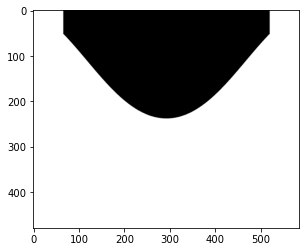

In [100]:

train_img = []

data_image = pd.read_csv("Data_folder/Picture.csv", header= None)

for img_name in data_image.iloc[0:,3:].index + 1:
    # defining the image path
    image_path = 'Data_folder/' + str(img_name) + '.png'
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)
    
plt.imshow(train_img[0], cmap='gray')
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:,3:].values
train_x_pic, val_x_pic, train_y_pic, val_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.1)
(train_x_pic.shape, train_y_pic.shape), (val_x_pic.shape, val_y_pic.shape)



In [101]:
# converting the target into torch format
train_y_pic = train_y_pic.astype(int);
train_y_pic = torch.from_numpy(train_y_pic)

train_x_pic = train_x_pic.reshape(25, 1, 479, 586)
train_x_pic  = torch.from_numpy(train_x_pic)

train_y_pic.shape, train_x_pic.shape

# converting validation images into torch format
val_x_pic = val_x_pic.reshape(3, 1, 479, 586)
val_x_pic  = torch.from_numpy(val_x)

# converting the target into torch format
val_y_pic = val_y.astype(int);
val_y_pic = torch.from_numpy(val_y)

# shape of validation data
val_x_pic.shape, val_y_pic.shape

(torch.Size([2, 479, 586]), torch.Size([2, 160]))

### Deside to apply host or device


In [102]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


### Define the functions we need

In [103]:
def loss_cal_per_epoch(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def train(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_per_epoch(loss_train, model, train_loader)
        loss_cal_per_epoch(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
    
    x = range(1, epochs+1)

    plt.plot(x, loss_train, 'b-', label="training loss")
    plt.plot(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score


### Train PhysicsNet

In [104]:
in_channel = 160
node_1 = 512
node_2 = 256
node_3 = 128
node_4 = 64
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 100

train(model_physics, optimizer, epoch)
PATH_CAL = os.path.join(os.getcwd(), "model_cal")
torch.save(model_physics, PATH_CAL)

epoch 1: train_loss = 19.6892, val_loss = 29.8582
epoch 2: train_loss = 6.1559, val_loss = 10.7513
epoch 3: train_loss = 4.1957, val_loss = 6.4638
epoch 4: train_loss = 2.9718, val_loss = 4.7152
epoch 5: train_loss = 0.8011, val_loss = 1.1282
epoch 6: train_loss = 0.9517, val_loss = 1.8216
epoch 7: train_loss = 1.1706, val_loss = 1.8463
epoch 8: train_loss = 1.1218, val_loss = 1.4373
epoch 9: train_loss = 0.8172, val_loss = 1.6976
epoch 10: train_loss = 0.4158, val_loss = 0.3702
epoch 11: train_loss = 0.3874, val_loss = 0.4503
epoch 12: train_loss = 0.3271, val_loss = 0.5344
epoch 13: train_loss = 0.4376, val_loss = 0.5190
epoch 14: train_loss = 1.3397, val_loss = 1.6451
epoch 15: train_loss = 0.3886, val_loss = 0.3848
epoch 16: train_loss = 0.3422, val_loss = 0.3420


KeyboardInterrupt: 

# Train PictureNet


In [ ]:
####To be done

### Visualization of outcomes

In [7]:
model_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_trained, x_test_example)

# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:8])
print("Prediction    =", score_example[:8].reshape(8, 2))

Ground Truths = tensor([[ 9.8000,  3.9000],
        [ 5.7000,  1.7000],
        [ 7.7000,  2.5000],
        [11.6000,  3.7000],
        [ 4.5000,  1.2000],
        [ 9.8000,  3.4000],
        [ 5.9000,  2.0000],
        [11.4000,  3.1000]])
Prediction    = tensor([[10.3801,  4.2324],
        [ 5.0403,  1.7249],
        [ 7.1923,  2.3698],
        [11.5871,  4.0177],
        [ 3.3756,  1.2351],
        [10.6139,  3.6268],
        [ 5.0317,  1.9173],
        [11.0337,  3.4015]])
